In [21]:
import BioSimSpace as BSS
import pandas as pd
from scipy import stats
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import minmax_scale
import glob
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
from itertools import chain
import os
import shutil
from functools import reduce

# Compare ML scoring versus LOMAP
~160 perturbations run in quintuplicate by Cresset across the JACS sets.

In [2]:
def computeLOMAPScore(tgt, lig1_name, lig2_name):
    """Computes a LOMAP score (version Flare v4) on a pair of ligands, returns the value."""
    lig_1 = Chem.MolFromMol2File(f"../../fep_ref_ligands/{tgt}/lig_{lig1_name}.mol2", sanitize=False, removeHs=False)
    lig_2 = Chem.MolFromMol2File(f"../../fep_ref_ligands/{tgt}/lig_{lig2_name}.mol2", sanitize=False, removeHs=False)
    MC = MCS(lig_1, lig_2, argparse.Namespace(time=20, verbose='pedantic', max3d=5, threed=True))
    
    # Rules calculations
    mcsr = MC.mcsr()
    strict = MC.tmcsr(strict_flag=True)
    loose = MC.tmcsr(strict_flag=False)
    mncar = MC.mncar()
    atnum = MC.atomic_number_rule()
    hybrid = MC.hybridization_rule()
    sulf = MC.sulfonamides_rule()
    het = MC.heterocycles_rule()
    growring = MC.transmuting_methyl_into_ring_rule()
    changering = MC.transmuting_ring_sizes_rule()
    
    # apply rules and compute final score.
    score = mncar * mcsr * atnum * hybrid
    score *= sulf * het * growring
    score *= changering
    
    return score

In [3]:
def computeLOMAPScores(tgt, ligs, perts):
    """For a given collection of perturbations, return the LOMAP scores for each.
    Note that although it is technically possible to calculate LOMAP for a single edge, we'll take the
    BioSimSpace shortcut in this function."""
    
    # fix mcl1 discrepancy.
    if tgt == "MCL":
        tgt = "MCL1"
        
    path_to_ligands = f"../../fep_ref_ligands/{tgt.lower()}"
    ligand_files = [ f"{path_to_ligands}/lig_{lig}.mol2" for lig in ligs ]
    ligands = []
    ligand_names = []

    for filepath in ligand_files:
        # append the molecule object to a list.
        ligands.append(BSS.IO.readMolecules(filepath)[0])

        # append the molecule name to another list so that we can use the name of each molecule in our workflow.
        ligand_names.append(filepath.split("/")[-1].replace(".mol2",""))
    if os.path.exists("process/lomap/lomap_workdir"):
        shutil.rmtree("process/lomap/lomap_workdir")
    BSS.Align.generateNetwork(ligands, plot_network=False, names=ligand_names, 
                                                             work_dir="process/lomap/lomap_workdir")

    # now for all given perturbations, retrieve the LOMAP scores.
    lomap_perts = {}
    with open("process/lomap/lomap_workdir/outputs/lomap_score_with_connection.txt", "r") as lomap_file:
        reader = csv.reader(lomap_file)
        next(reader)
        for row in reader:
            cleaned_row = [ item.replace(" ","") for item in row ]

            lig1 = "_".join(cleaned_row[2].split("_")[1:]).split(".")[0].replace("lig_","")
            lig2 = "_".join(cleaned_row[3].split("_")[1:]).split(".")[0].replace("lig_","")
            lomap_pert = lig1+"~"+lig2
            lomap_perts[lomap_pert] = float(cleaned_row[4])
    picked_perts = {}
    for pert in perts:
        try:
            picked_perts[pert] = lomap_perts[pert]
        except KeyError:
            inv_pert = pert.split("~")[1]+"~"+pert.split("~")[0]
            picked_perts[pert] = lomap_perts[inv_pert]
    return picked_perts

In [4]:
cresset_df = pd.read_csv("output/sem_predictions_cresset_quintup.csv", index_col=False)
cresset_df

,tgt,pert_name,true_sem,pred_sem,random_sem,num_ha_change
0,BACE,CAT-4d~CAT-4b,0.094402,0.068686,0.390144,1
1,BACE,CAT-4l~CAT-4i,0.042104,0.120924,0.688069,1
2,BACE,CAT-4l~CAT-4a,0.082903,0.108708,0.528104,1
3,BACE,CAT-4b~CAT-4d,0.041804,0.047842,0.853101,1
4,BACE,CAT-13n~CAT-13j,0.158339,0.125925,0.666111,1
...,...,...,...,...,...,...
151,TYK2,jmc_28~jmc_30,0.020223,0.065350,0.816319,1
152,TYK2,ejm_45~ejm_31,0.300252,0.197630,0.311362,3
153,TYK2,ejm_46~jmc_28,0.101031,0.047842,0.713432,1
154,TYK2,jmc_30~ejm_46,0.091660,0.184355,0.018408,2


In [228]:
# # unfortunately this takes a while to run. On our system ~45 min, mostly due to BACE and MCL.
# lomap_scores = []
# for tgt in set(cresset_df["tgt"].values):
#     print(tgt)
    
#     # per target, run LOMAP on the ligands that exist in it, then parse the work_dir fully-connected to get
#     # the LOMAP scores for the perturbations we want. Add these to the dataframe.
#     perts = cresset_df[cresset_df["tgt"] == tgt]["pert_name"].values
#     perts_split = [pert.split("~") for pert in perts]
#     ligs = set(list(chain.from_iterable(perts_split)))
    
#     # compute scores for this group.
#     lomap_score_per_pert = computeLOMAPScores(tgt, ligs, perts)
    
#     # add as a column to the dataframe.
#     lomap_scores.append(cresset_df[cresset_df["tgt"] == tgt]["pert_name"].map(lomap_score_per_pert).values.tolist())
# lomap_scores = list(chain.from_iterable(lomap_scores))

# cresset_df["LOMAP-Score"] = lomap_scores

JNK1
BACE
CDK2
PTP1B
THROMBIN
TYK2
P38
MCL


In [5]:
#cresset_df.to_csv("output/sem_predictions_cresset_quintup_lomapd.csv")
cresset_df = pd.read_csv("output/sem_predictions_cresset_quintup_lomapd.csv")
cresset_df

,Unnamed: 0,tgt,pert_name,true_sem,pred_sem,random_sem,num_ha_change,LOMAP-Score
0,0,BACE,CAT-4d~CAT-4b,0.094402,0.068686,0.390144,1,0.81873
1,1,BACE,CAT-4l~CAT-4i,0.042104,0.120924,0.688069,1,0.81873
2,2,BACE,CAT-4l~CAT-4a,0.082903,0.108708,0.528104,1,0.81873
3,3,BACE,CAT-4b~CAT-4d,0.041804,0.047842,0.853101,1,0.81873
4,4,BACE,CAT-13n~CAT-13j,0.158339,0.125925,0.666111,1,0.90484
...,...,...,...,...,...,...,...,...
151,151,TYK2,jmc_28~jmc_30,0.020223,0.065350,0.816319,1,0.00000
152,152,TYK2,ejm_45~ejm_31,0.300252,0.197630,0.311362,3,0.00000
153,153,TYK2,ejm_46~jmc_28,0.101031,0.047842,0.713432,1,0.00000
154,154,TYK2,jmc_30~ejm_46,0.091660,0.184355,0.018408,2,0.00000


In [6]:
cresset_df = cresset_df[cresset_df.tgt != "CDK2"]

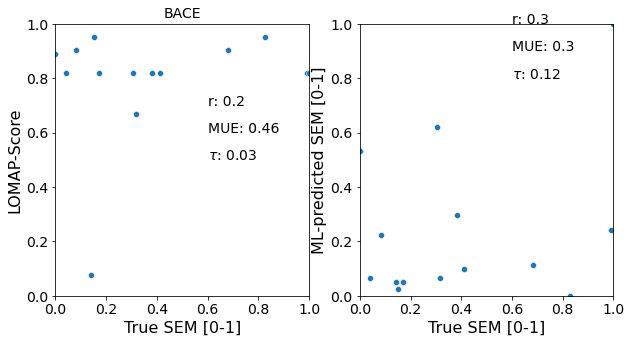

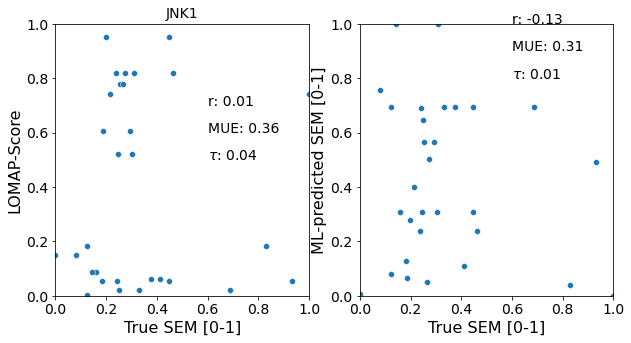

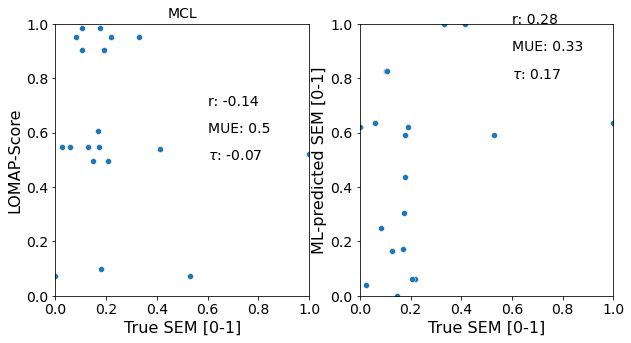

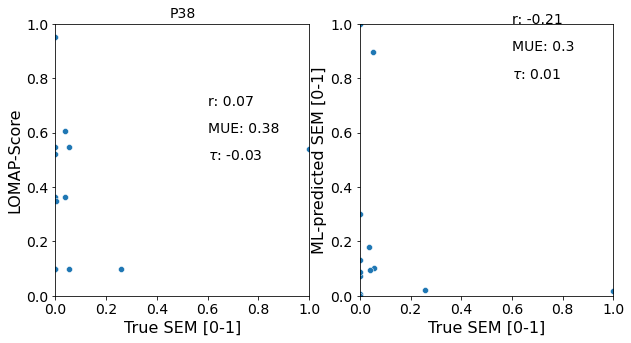

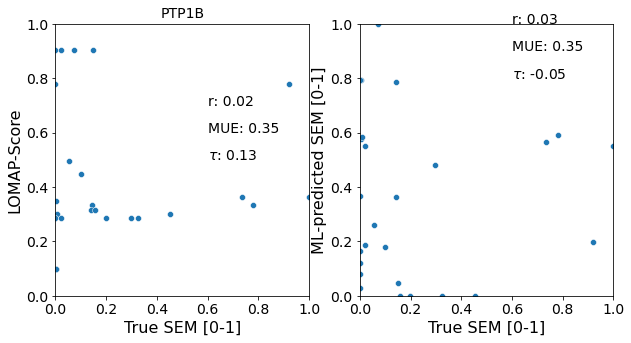

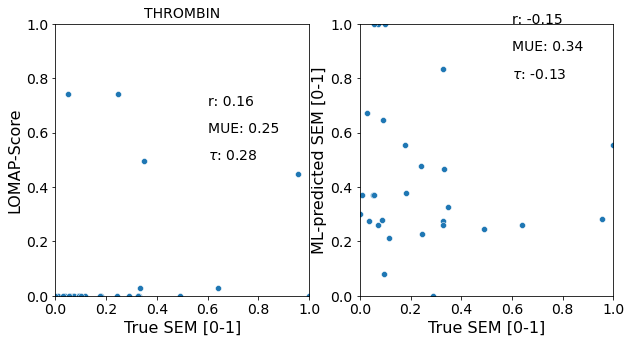

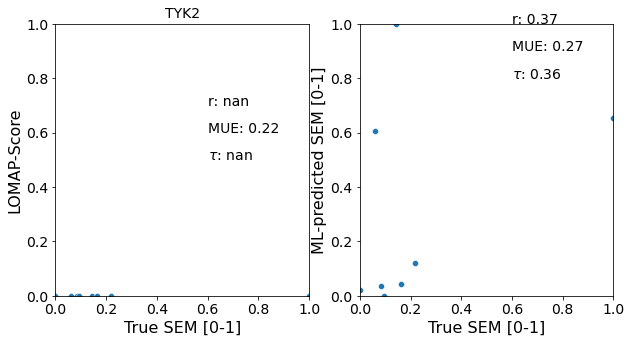

In [20]:
for tgt_group, data_df in cresset_df.groupby(by="tgt"):

    fig, axes = plt.subplots(1, 2, figsize=(10,5))

    true_sems = minmax_scale((1 / np.clip(data_df["true_sem"].values, 0, 1)), feature_range=(0,1))
    pred_sems = minmax_scale((1 / np.clip(data_df["pred_sem"].values, 0, 1)), feature_range=(0,1))

    data_df["True SEM [0-1]"] = true_sems
    data_df["Pred SEM [0-1]"] = pred_sems

    # axes[0].scatter(true_sems, cresset_df["LOMAP-Score"], color=colors)
    # axes[1].scatter(true_sems, pred_sems, color=colors)

    sns.scatterplot("True SEM [0-1]", "LOMAP-Score", data=data_df, ax=axes[0])
    sns.scatterplot("True SEM [0-1]", "Pred SEM [0-1]", data=data_df, ax=axes[1])

    r_left = round(stats.pearsonr(data_df["LOMAP-Score"], true_sems)[0], 2)
    mue_left = round(mean_absolute_error(data_df["LOMAP-Score"], true_sems), 2)
    tau_left = round(stats.kendalltau(data_df["LOMAP-Score"], true_sems)[0], 2)
    r_right = round(stats.pearsonr(pred_sems, true_sems)[0], 2)
    mue_right = round(mean_absolute_error(pred_sems, true_sems), 2)
    tau_right = round(stats.kendalltau(pred_sems, true_sems)[0], 2)

    axes[0].annotate("r: "+str(r_left), xy=(0.6, 0.7))
    axes[0].annotate("MUE: "+str(mue_left), xy=(0.6, 0.6))
    axes[0].annotate(r"$\tau$: "+str(tau_left), xy=(0.6, 0.5))

    axes[1].annotate("r: "+str(r_right), xy=(0.6, 1))
    axes[1].annotate("MUE: "+str(mue_right), xy=(0.6, 0.9))
    axes[1].annotate(r"$\tau$: "+str(tau_right), xy=(0.6, 0.8))
    
    lim = (0,1)
    for ax in axes:
        ax.set_xlim(lim)
        ax.set_ylim(lim)
    axes[0].set_title(tgt_group)
    axes[0].set_xlabel("True SEM [0-1]")
    axes[1].set_xlabel("True SEM [0-1]")
    axes[0].set_ylabel("LOMAP-Score")
    axes[1].set_ylabel("ML-predicted SEM [0-1]")
    axes[0].legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)

    plt.show()

# Analyse a single congeneric series: TYK2
## File preparation
Write a links file for all types of LOMAP input that we can generate, including LOMAP-Scores.

In [2]:
def generateLinksFiles(preds_path):
    """Given a csv file with SEM predictions, write out links files for LOMAP.
    Because SEMs are the inverse of LOMAP (i.e. LOMAP-score 0.0 is poor, but SEM 0.0 is good), 
    we need to invert the predicted SEM values. Additionally, compress them to fall in the range 0-1 
    as is the case with LOMAP-scores."""
    
    preds_df = pd.read_csv(preds_path)
    print(preds_df)
    
    pert_names = preds_df["pert_name"].values
    
    # for these, take inverse and scale to 0-1.
    true_sems = minmax_scale(1 / preds_df["true_sem"].values, feature_range=(0,1))
    pred_sems = minmax_scale(1 / preds_df["pred_sem"].values, feature_range=(0,1))
    
    random_sems = preds_df["random_sem"].values
    return pert_names, true_sems, pred_sems, random_sems
        
def writeLinksFile(pert_names, values, filename):
    with open(filename, "w") as writefile:
        writer = csv.writer(writefile, delimiter =" ")
        for pert_name, value in zip(pert_names, values):
            writer.writerow([pert_name, value])
        
pert_names, true_sems, pred_sems, random_sems = generateLinksFiles("output/sem_predictions_jnk1.csv")

writeLinksFile(pert_names, true_sems, "process/lomap/lomap_inputs_true_sems.csv")
writeLinksFile(pert_names, pred_sems, "process/lomap/lomap_inputs_pred_sems.csv")
writeLinksFile(pert_names, random_sems, "process/lomap/lomap_inputs_rand_sems.csv")

                   pert_name  true_sem  pred_sem  random_sem  num_ha_change
0    lig_18627-1~lig_18628-1  0.202196  0.051757    0.585736              1
1    lig_18627-1~lig_18625-1  0.187456  0.061679    0.328167             -1
2    lig_18626-1~lig_18624-1  0.099644  0.082635    0.962565              1
3    lig_18658-1~lig_18635-1  0.117091  0.907779    0.623443              5
4    lig_18637-1~lig_18660-1  0.705373  0.220036    0.323150              1
..                       ...       ...       ...         ...            ...
415  lig_18638-1~lig_18658-1  0.197203  0.122402    0.305397              4
416  lig_18638-1~lig_18635-1  0.152065  1.053349    0.364954              8
417  lig_18627-1~lig_18635-1  0.161416  0.066940    0.547552              2
418  lig_18629-1~lig_18630-1  0.042743  0.056602    0.393715              1
419  lig_18625-1~lig_18636-1  0.154168  0.055136    0.539199              0

[420 rows x 5 columns]


In [3]:
# run LOMAP on the JNK1 set so that we can grab the scores.
path_to_ligands = "input/JNK1_FULLY_CONNECTED_TESTSET/ligand_files"
ligand_files = glob.glob(f"{path_to_ligands}/*.mol2")

ligands = []
ligand_names = []

for filepath in ligand_files:
    # append the molecule object to a list.
    ligands.append(BSS.IO.readMolecules(filepath)[0])
    
    # append the molecule name to another list so that we can use the name of each molecule in our workflow.
    ligand_names.append(filepath.split("/")[-1].replace(".mol2",""))

tranformations, lomap_scores = BSS.Align.generateNetwork(ligands, plot_network=False, names=ligand_names, 
                                                         work_dir="process/lomap/lomap_workdir")

In [4]:
# instead of the normal approach (see BSS tutorial), find the LOMAP score for 
# the fully-connected network in the work_dir.
lomap_perts = []
lomap_scores = []

with open("process/lomap/lomap_workdir/outputs/lomap_score_with_connection.txt", "r") as lomap_file:
    reader = csv.reader(lomap_file)
    next(reader)
    for row in reader:
        cleaned_row = [ item.replace(" ","") for item in row ]
        
        lig1 = "_".join(cleaned_row[2].split("_")[1:]).split(".")[0]
        lig2 = "_".join(cleaned_row[3].split("_")[1:]).split(".")[0]
        pert = lig1+"~"+lig2
        lomap_score = float(cleaned_row[4])
        lomap_perts.append(pert)
        lomap_scores.append(lomap_score)
        
        # lomap's mtx edges are monodirectional, but our predictions are bidirectional. Write both directions.
        inv_pert = lig2+"~"+lig1
        lomap_perts.append(inv_pert)
        lomap_scores.append(lomap_score)        
        
writeLinksFile(lomap_perts, lomap_scores, "process/lomap/lomap_inputs_lomap_scores.csv")

## Analyse SEM correlations
Plot all possible combinations of data in scatterplots, i.e. lomap, true sem, pred sem, rand sem.


In [5]:
true_sems_df = pd.read_csv("process/lomap/lomap_inputs_true_sems.csv", names=["Perturbation", "True SEM [0-1]"], sep=" ")
pred_sems_df = pd.read_csv("process/lomap/lomap_inputs_pred_sems.csv", names=["Perturbation", "ML-Predicted\nSEM [0-1]"], sep=" ")
rand_sems_df = pd.read_csv("process/lomap/lomap_inputs_rand_sems.csv", names=["Perturbation", "Random\nSEM [0-1]"], sep=" ")
lomap_sems_df = pd.read_csv("process/lomap/lomap_inputs_lomap_scores.csv", names=["Perturbation", "LOMAP-Score"], sep=" ").drop_duplicates(subset="Perturbation")

# add the number of heavy atoms perturbed.
num_ha = pd.read_csv("output/tmp_sem_predictions_jnk1.csv", usecols=[0, 4])
num_ha.columns = ["Perturbation","Heavy Atoms Perturbed"]

# create a single dataframe.
sems_combined_df = reduce(lambda left,right: pd.merge(left,right,on='Perturbation'), 
      [true_sems_df, rand_sems_df, pred_sems_df, lomap_sems_df, num_ha])
sems_combined_df

,Perturbation,True SEM [0-1],Random\nSEM [0-1],ML-Predicted\nSEM [0-1],LOMAP-Score,Heavy Atoms Perturbed
0,lig_18627-1~lig_18628-1,0.076424,0.585736,0.712653,0.81873,0
1,lig_18627-1~lig_18625-1,0.083727,0.328167,0.594136,0.81873,3
2,lig_18626-1~lig_18624-1,0.172007,0.962565,0.437356,0.90484,2
3,lig_18658-1~lig_18635-1,0.143927,0.623443,0.017924,0.49659,2
4,lig_18637-1~lig_18660-1,0.010174,0.323150,0.149213,0.44933,6
...,...,...,...,...,...,...
415,lig_18638-1~lig_18658-1,0.078775,0.305397,0.287441,0.60653,9
416,lig_18638-1~lig_18635-1,0.107041,0.364954,0.012119,0.36788,9
417,lig_18627-1~lig_18635-1,0.099887,0.547552,0.545546,0.74082,3
418,lig_18629-1~lig_18630-1,0.422884,0.393715,0.649590,0.81873,3


In [ ]:
def computeStats(input_df):
    """return statistics input for table to plot."""
    col_labels = ["Random", "ML", "LOMAP"]
    row_labels = ["Pearson r", "MUE /\nkcal$\cdot$mol$^{-1}$", r"Kendall $\tau$"]
    table_vals = []
    for array in [input_df["Random\nSEM [0-1]"], 
                  input_df["ML-Predicted\nSEM [0-1]"],
                  input_df["LOMAP-Score"]
                 ]:
        

        r = round(stats.pearsonr(input_df["True SEM [0-1]"], array)[0], 2)
        mue = round(mean_absolute_error(input_df["True SEM [0-1]"], array), 2)
        tau = round(stats.kendalltau(input_df["True SEM [0-1]"], array)[0], 2)
        table_vals.append([r, mue, tau])
        
    # need to transpose table values to fit the row/col layout.
    table_vals = np.array(table_vals).T.tolist()
    return col_labels, row_labels, table_vals
    
col_labels, row_labels, table_vals = computeStats(sems_combined_df)

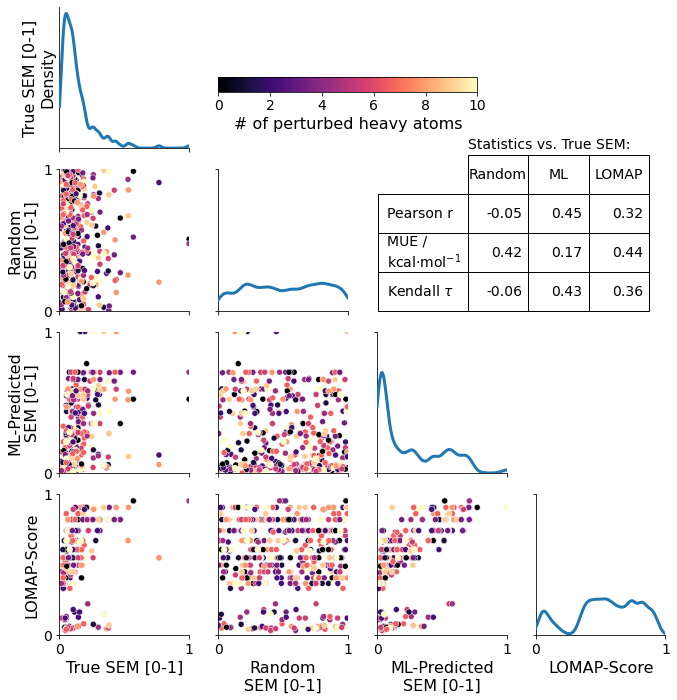

In [7]:
data = sems_combined_df

# make a pairplot.
g = sns.PairGrid(data, hue="Heavy Atoms Perturbed", palette='magma')
g.map_lower(sns.scatterplot)
g.map_diag(sns.kdeplot, lw=3, hue=None, bw_adjust=0.5, clip=(0.0, 1.0))


# create the colorbar.
norm = plt.Normalize(data["Heavy Atoms Perturbed"].min(), data["Heavy Atoms Perturbed"].max()+1)
sm = plt.cm.ScalarMappable(cmap="magma", norm=norm)
sm.set_array([])

axins = inset_axes(g.axes.flatten()[1],
                   width="200%",  # width = 5% of parent_bbox width
                   height="10%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(0.0, 0.4, 1, 1),
                   bbox_transform=g.axes.flatten()[1].transAxes,
                   borderpad=0,
                   )

cbar = g.figure.colorbar(sm, shrink=1.5, cax=axins, orientation="horizontal")
cbar.set_label('# of perturbed heavy atoms')


# hide empty graphs.
for i, ax in enumerate(g.axes.flatten()):
    if i in [1, 2, 3, 6, 7, 11]:
        ax.axis("off")
        

#adjust ticks such that each plot just shows 0 and 1.
for ax in g.axes.flatten():
    ax.xaxis.set_major_locator(plt.MaxNLocator(1))
    ax.yaxis.set_major_locator(plt.MaxNLocator(1))
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    
# Hide y ticks in true SEM density plot to avoid confusion.
g.axes.flatten()[0].set_yticks([])
g.axes.flatten()[0].set_ylabel("True SEM [0-1]\nDensity")

table = g.axes.flatten()[6].table(cellText=table_vals,
                  rowLabels=row_labels,
                  colLabels=col_labels,
                  bbox=[0.7, 0, 1.4, 1.1])
table.auto_set_font_size(False)
table.set_fontsize(14)
g.axes.flatten()[2].annotate("Statistics vs. True SEM:",xy=(0.7,0))
plt.show()

## Network generation and analysis
Generate networks with links_files. Run a LOMAP function for each. Compute Sum of SEMs for each.

In [8]:
def runLOMAP(links_file):
    # run LOMAP on the JNK1 set so that we can grab the scores.
    path_to_ligands = "input/JNK1_FULLY_CONNECTED_TESTSET/ligand_files"
    ligand_files = glob.glob(f"{path_to_ligands}/*.mol2")

    ligands = []
    ligand_names = []

    for filepath in ligand_files:
        # append the molecule object to a list.
        ligands.append(BSS.IO.readMolecules(filepath)[0])

        # append the molecule name to another list so that we can use the name of each molecule in our workflow.
        ligand_names.append(filepath.split("/")[-1].replace(".mol2",""))

    # bit of a workaround, but we have to find the mol2 file names that LOMAP uses internally.  
    # write out a second linksfile that doesn't have the tilde to denote the perturbations. Also
    # use glob in the pre-generated LOMAP work folder to find what we should call our ligands (i.e.
    # refer to the internal LOMAP file name).
    links_file_contents = pd.read_csv(links_file, sep=" ", header=None)
    lomap_internal_files = glob.glob("process/lomap/lomap_workdir/inputs/*.mol2")
    internal_links_file_path = links_file.replace(".csv", "_internal.csv")
    
    with open(internal_links_file_path, "w") as writefile:
        writer = csv.writer(writefile, delimiter =" ")
              
        for pert_name, value in zip(links_file_contents[0].values, links_file_contents[1].values):

            # find the internal path.
            for lig in lomap_internal_files:
                if pert_name.split("~")[0] in lig:
                    lig1 = lig.split("/")[-1]
                elif pert_name.split("~")[1] in lig:
                    lig2 = lig.split("/")[-1]
                                
            writer.writerow([lig1, lig2, value])
    
    
    
    # now run LOMAP with the pre-specified edge scorings.
    tranformations, lomap_scores = BSS.Align.generateNetwork(ligands, plot_network=False, names=ligand_names,
                                                            links_file=internal_links_file_path)
    
    pert_network_dict = {}
    transformations_named = [(ligand_names[transf[0]], ligand_names[transf[1]]) for transf in tranformations]
    for transf, score in zip(transformations_named, lomap_scores):
        transf_tilde = "~".join(transf)
        pert_network_dict[transf_tilde] = score
    
    return tranformations, lomap_scores, pert_network_dict

In [9]:
def calcSumOfSEMs(pert_network_dict, true_sems_df):
    """Given a specific combination of edges, computes the sum of True SEMs in the network."""
    true_sems_per_edge = []
    perts = []
    for pert, v in pert_network_dict.items():
        # from the dataframe with true sems, find the true sem for this edge that LOMAP has suggested.
        sem_this_pert = true_sems_df[true_sems_df["Perturbation"] == pert]["True SEM"].values[0]
        
        true_sems_per_edge.append(sem_this_pert)
        perts.append(pert)
    
    return true_sems_per_edge, len(true_sems_per_edge), perts

In [10]:
_, lomap_scores_random, pert_network_dict_random = runLOMAP("process/lomap/lomap_inputs_rand_sems.csv")
_, lomap_scores_pred, pert_network_dict_pred = runLOMAP("process/lomap/lomap_inputs_pred_sems.csv")
_, lomap_scores_lomap, pert_network_dict_lomap = runLOMAP("process/lomap/lomap_inputs_lomap_scores.csv")
_, lomap_scores_true_sem, pert_network_dict_true_sem = runLOMAP("process/lomap/lomap_inputs_true_sems.csv")

Added prespecified link for mols ['007_lig_18627-1.mol2', '002_lig_18628-1.mol2', '0.5857355000876294'] -> (7, 2) score 0.5857355000876294
Added prespecified link for mols ['007_lig_18627-1.mol2', '020_lig_18625-1.mol2', '0.3281665894468049'] -> (7, 20) score 0.3281665894468049
Added prespecified link for mols ['010_lig_18626-1.mol2', '008_lig_18624-1.mol2', '0.9625649494616314'] -> (10, 8) score 0.9625649494616314
Added prespecified link for mols ['014_lig_18658-1.mol2', '015_lig_18635-1.mol2', '0.6234425157515872'] -> (14, 15) score 0.6234425157515872
Added prespecified link for mols ['011_lig_18637-1.mol2', '018_lig_18660-1.mol2', '0.3231498015115123'] -> (11, 18) score 0.3231498015115123
Added prespecified link for mols ['009_lig_18633-1.mol2', '020_lig_18625-1.mol2', '0.8172524972417736'] -> (9, 20) score 0.8172524972417736
Added prespecified link for mols ['006_lig_17124-1.mol2', '003_lig_18638-1.mol2', '0.2934826791975478'] -> (6, 3) score 0.2934826791975478
Added prespecified l

Added prespecified link for mols ['007_lig_18627-1.mol2', '002_lig_18628-1.mol2', '0.7126525636433054'] -> (7, 2) score 0.7126525636433054
Added prespecified link for mols ['007_lig_18627-1.mol2', '020_lig_18625-1.mol2', '0.5941364571105294'] -> (7, 20) score 0.5941364571105294
Added prespecified link for mols ['010_lig_18626-1.mol2', '008_lig_18624-1.mol2', '0.4373564151114692'] -> (10, 8) score 0.4373564151114692
Added prespecified link for mols ['014_lig_18658-1.mol2', '015_lig_18635-1.mol2', '0.0179238595271459'] -> (14, 15) score 0.0179238595271459
Added prespecified link for mols ['011_lig_18637-1.mol2', '018_lig_18660-1.mol2', '0.1492129274057596'] -> (11, 18) score 0.1492129274057596
Added prespecified link for mols ['009_lig_18633-1.mol2', '020_lig_18625-1.mol2', '0.42161937878743'] -> (9, 20) score 0.42161937878743
Added prespecified link for mols ['006_lig_17124-1.mol2', '003_lig_18638-1.mol2', '0.1024618702179942'] -> (6, 3) score 0.1024618702179942
Added prespecified link 

Added prespecified link for mols ['000_lig_18634-1.mol2', '001_lig_18652-1.mol2', '0.60653'] -> (0, 1) score 0.60653
Added prespecified link for mols ['001_lig_18652-1.mol2', '000_lig_18634-1.mol2', '0.60653'] -> (1, 0) score 0.60653
Added prespecified link for mols ['000_lig_18634-1.mol2', '002_lig_18628-1.mol2', '0.18268'] -> (0, 2) score 0.18268
Added prespecified link for mols ['002_lig_18628-1.mol2', '000_lig_18634-1.mol2', '0.18268'] -> (2, 0) score 0.18268
Added prespecified link for mols ['000_lig_18634-1.mol2', '003_lig_18638-1.mol2', '0.67032'] -> (0, 3) score 0.67032
Added prespecified link for mols ['003_lig_18638-1.mol2', '000_lig_18634-1.mol2', '0.67032'] -> (3, 0) score 0.67032
Added prespecified link for mols ['000_lig_18634-1.mol2', '004_lig_18630-1.mol2', '0.60653'] -> (0, 4) score 0.60653
Added prespecified link for mols ['004_lig_18630-1.mol2', '000_lig_18634-1.mol2', '0.60653'] -> (4, 0) score 0.60653
Added prespecified link for mols ['000_lig_18634-1.mol2', '005_l

Added prespecified link for mols ['007_lig_18627-1.mol2', '002_lig_18628-1.mol2', '0.0764240587092171'] -> (7, 2) score 0.0764240587092171
Added prespecified link for mols ['007_lig_18627-1.mol2', '020_lig_18625-1.mol2', '0.0837267935998953'] -> (7, 20) score 0.0837267935998953
Added prespecified link for mols ['010_lig_18626-1.mol2', '008_lig_18624-1.mol2', '0.1720068117340741'] -> (10, 8) score 0.1720068117340741
Added prespecified link for mols ['014_lig_18658-1.mol2', '015_lig_18635-1.mol2', '0.1439269030124928'] -> (14, 15) score 0.1439269030124928
Added prespecified link for mols ['011_lig_18637-1.mol2', '018_lig_18660-1.mol2', '0.0101737090849178'] -> (11, 18) score 0.0101737090849178
Added prespecified link for mols ['009_lig_18633-1.mol2', '020_lig_18625-1.mol2', '0.1153048965676888'] -> (9, 20) score 0.1153048965676888
Added prespecified link for mols ['006_lig_17124-1.mol2', '003_lig_18638-1.mol2', '0.072243236912319'] -> (6, 3) score 0.072243236912319
Added prespecified lin

Added prespecified link for mols ['002_lig_18628-1.mol2', '004_lig_18630-1.mol2', '0.3733542396672998'] -> (2, 4) score 0.3733542396672998
Added prespecified link for mols ['002_lig_18628-1.mol2', '015_lig_18635-1.mol2', '0.3425762132073092'] -> (2, 15) score 0.3425762132073092
Added prespecified link for mols ['006_lig_17124-1.mol2', '012_lig_18631-1.mol2', '0.068078146031992'] -> (6, 12) score 0.068078146031992
Added prespecified link for mols ['006_lig_17124-1.mol2', '001_lig_18652-1.mol2', '0.0445513795184326'] -> (6, 1) score 0.0445513795184326
Added prespecified link for mols ['001_lig_18652-1.mol2', '015_lig_18635-1.mol2', '0.0213259711035676'] -> (1, 15) score 0.0213259711035676
Added prespecified link for mols ['006_lig_17124-1.mol2', '015_lig_18635-1.mol2', '0.0709650031675048'] -> (6, 15) score 0.0709650031675048
Added prespecified link for mols ['019_lig_18632-1.mol2', '004_lig_18630-1.mol2', '0.0967487255343472'] -> (19, 4) score 0.0967487255343472
Added prespecified link 

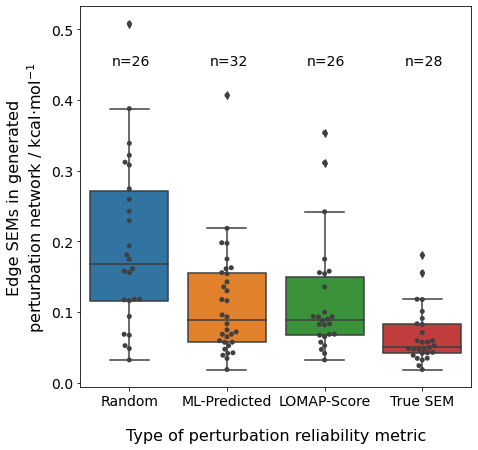

In [11]:
original_true_sems_df = pd.read_csv("output/tmp_sem_predictions_jnk1.csv", usecols=(0,1))
original_true_sems_df.columns = ["Perturbation", "True SEM"]

true_sems_random, num_edges_random, perts_random = calcSumOfSEMs(pert_network_dict_random, original_true_sems_df)
true_sems_pred, num_edges_pred, perts_pred = calcSumOfSEMs(pert_network_dict_pred, original_true_sems_df)
true_sems_lomap, num_edges_lomap, perts_lomap = calcSumOfSEMs(pert_network_dict_lomap, original_true_sems_df)
true_sems_true, num_edges_true, perts_true = calcSumOfSEMs(pert_network_dict_true_sem, original_true_sems_df)

# bit annoying to have to switch to pandas again to accommodate seaborn's api..
random_df = pd.DataFrame(true_sems_random)
random_df.columns = ["SEM"]
random_df["SCORING_TYPE"] = "Random"
random_df["PERT"] = perts_random

pred_df = pd.DataFrame(true_sems_pred)
pred_df.columns = ["SEM"]
pred_df["SCORING_TYPE"] = "ML-Predicted"
pred_df["PERT"] = perts_pred

lomap_df = pd.DataFrame(true_sems_lomap)
lomap_df.columns = ["SEM"]
lomap_df["SCORING_TYPE"] = "LOMAP-Score"
lomap_df["PERT"] = perts_lomap

true_df = pd.DataFrame(true_sems_true)
true_df.columns = ["SEM"]
true_df["SCORING_TYPE"] = "True SEM"
true_df["PERT"] = perts_true

concat_df = pd.concat([random_df, pred_df, lomap_df, true_df], ignore_index=True)
plt.figure(figsize=(7,7))
ax = sns.boxplot(x="SCORING_TYPE", y="SEM", data=concat_df)
ax = sns.swarmplot(x="SCORING_TYPE", y="SEM", data=concat_df, color=".25")

for i, num in enumerate([num_edges_random, num_edges_pred, num_edges_lomap, num_edges_true]):
    ax.annotate("n="+str(num), xy=(i-0.18,0.45))
    
plt.xlabel("Type of perturbation reliability metric", labelpad=20)
#plt.xticks(rotation=15) 
plt.ylabel("Edge SEMs in generated\nperturbation network / kcal$\cdot$mol$^{-1}$")

plt.show()

In [12]:
from rdkit import Chem

In [13]:
lomap_df.sort_values(by="SEM", ascending=False).head(5)

,SEM,SCORING_TYPE,PERT
6,0.353654,LOMAP-Score,lig_18634-1~lig_18660-1
0,0.311157,LOMAP-Score,lig_18634-1~lig_18652-1
1,0.241775,LOMAP-Score,lig_18634-1~lig_18638-1
15,0.174700,LOMAP-Score,lig_17124-1~lig_18637-1
3,0.157600,LOMAP-Score,lig_18634-1~lig_18637-1


In [14]:
pred_df.sort_values(by="SEM", ascending=False).head(5)

,SEM,SCORING_TYPE,PERT
23,0.406713,ML-Predicted,lig_18637-1~lig_18658-1
8,0.218318,ML-Predicted,lig_18638-1~lig_18659-1
30,0.197948,ML-Predicted,lig_18659-1~lig_18660-1
7,0.197203,ML-Predicted,lig_18638-1~lig_18658-1
15,0.174911,ML-Predicted,lig_18627-1~lig_18629-1


In [18]:
true_df.sort_values(by="SEM", ascending=False).head(5)

,SEM,SCORING_TYPE,PERT
9,0.180642,True SEM,lig_18638-1~lig_18660-1
26,0.155635,True SEM,lig_18658-1~lig_18660-1
5,0.117911,True SEM,lig_18628-1~lig_18636-1
22,0.117513,True SEM,lig_18637-1~lig_18659-1
21,0.100826,True SEM,lig_18637-1~lig_18629-1


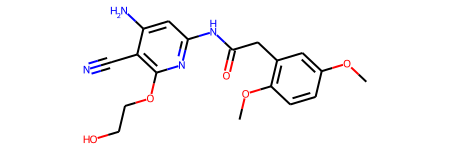

In [21]:
mol = Chem.MolFromMol2File("input/JNK1_FULLY_CONNECTED_TESTSET/ligand_files/lig_18658-1.mol2")
Chem.rdDepictor.Compute2DCoords(mol)
mol

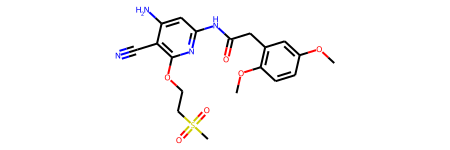

In [20]:
mol = Chem.MolFromMol2File("input/JNK1_FULLY_CONNECTED_TESTSET/ligand_files/lig_18660-1.mol2")
Chem.rdDepictor.Compute2DCoords(mol)
mol

## Analyse Free Energies vs. Expt per generated network

In [17]:
# for all the generated networks, let freenrgworkflows compute ddGs per ligand. Compare this to experiment.
# probably not as good as state-of-the-art bc we've run 1ns for the fully connected network.

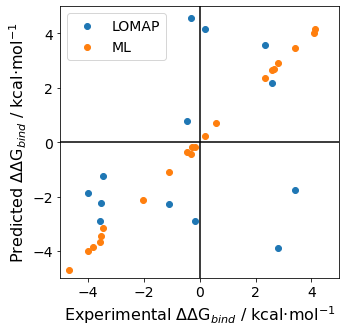

In [71]:
# mock figure.
expt = np.random.uniform(low=-5, high=5, size=(21,))
lomap = expt + np.random.normal(0, 3, expt.shape)
ml_lomap = expt + np.random.normal(0, 0.1, expt.shape)


plt.figure(figsize=(5,5))
plt.scatter(expt, lomap, label="LOMAP")
plt.scatter(expt, ml_lomap, label="ML")
plt.axhline(color="black")
plt.axvline(color="black")

plt.xlim(-5,5)
plt.ylim(-5,5)

plt.xlabel("Experimental $\Delta\Delta$G$_{bind}$ / kcal$\cdot$mol$^{-1}$")
plt.ylabel("Predicted $\Delta\Delta$G$_{bind}$ / kcal$\cdot$mol$^{-1}$")
plt.legend()
plt.show()